<a href="https://colab.research.google.com/github/DanielCoser/Webscrapping-ML/blob/main/An%C3%A1lise_Explorat%C3%B3ria_de_Dados_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
from time import sleep

zonas = ['sul', 'oeste', 'leste', 'norte']
paginas = ['', '_Desde_49', '_Desde_97', '_Desde_145', '_Desde_193']
url_ml = 'https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/'

def coletando_dados(url, zona):

  resposta = requests.get(url).content
  sopa = BeautifulSoup(resposta)

  result_set_precos = sopa.find_all('span', {'class': 'price-tag-fraction'})
  result_set_area_quartos = sopa.find_all('ul', class_='ui-search-card-attributes ui-search-item__group__element')
  result_set_enderecos = sopa.find_all('span', class_='ui-search-item__group__element ui-search-item__location')

  lista_precos = []
  lista_area_quartos = []
  lista_enderecos = []
  lista_zonas = []

  for preco, area_quarto, endereco in zip(result_set_precos, result_set_area_quartos, result_set_enderecos):
    lista_precos.append(preco.text)
    lista_area_quartos.append(area_quarto.text)
    lista_enderecos.append(endereco.text)
    lista_zonas.append(zona)
    
  dados = {'zonas': lista_zonas,
           'areas_quartos': lista_area_quartos,
           'enderecos': lista_enderecos,
           'precos': lista_precos}

  df = pd.DataFrame(dados)
  return df

In [31]:
lista_dados = []

for zona in zonas:
  for pagina in paginas:
    url = f'https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-{zona}/{pagina}'
    print('Coletando dados de', url)
    df = coletando_dados(url, zona)
    lista_dados.append(df)
    sleep(2) # lembrar de usar sleep para não sobrecarregar o site de acessos
print('Dados coletados!')

Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-sul/
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-sul/_Desde_49
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-sul/_Desde_97
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-sul/_Desde_145
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-sul/_Desde_193
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-oeste/
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-oeste/_Desde_49
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-paulo-zona-oeste/_Desde_97
Coletando dados de https://imoveis.mercadolivre.com.br/apartamentos/aluguel/sao-paulo/sao-

In [32]:
df_dados = pd.concat(lista_dados)
df_dados
df_dados['areas_quartos'] = df_dados['areas_quartos'].str.replace(',','.')

In [33]:
df_dados.to_csv('dados_mercado_livre.csv', index=False) # index=False para tirar o unnamed - coluna adicional de indices

In [34]:
import re
df_ml = pd.read_csv('dados_mercado_livre.csv', thousands='.')
df_ml.head()

,zonas,areas_quartos,enderecos,precos
0,sul,45 m² construídos1 quarto,"Rua Doutor Fadlo Haidar,\n 75, ...",3200
1,sul,88 m² construídos3 quartos,"R Apotribu, Parque Imperial, São Paulo Zona Su...",2800
2,sul,83 m² construídos3 quartos,"Av Mascote, Vila Mascote, São Paulo Zona Sul, ...",3500
3,sul,51 m² construídos2 quartos,"Rua Taquacetuba, Vila Parque Jabaquara, São Pa...",1200
4,sul,48 m² construídos1 quarto,"Rua Charles Spencer Chaplin, Vila Andrade, São...",1906


In [35]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zonas          960 non-null    object
 1   areas_quartos  960 non-null    object
 2   enderecos      960 non-null    object
 3   precos         960 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 30.1+ KB


In [36]:
linha_0 = df_ml['areas_quartos'][0]
df_ml['areas_quartos'][706]

'45 m² construídos2 quartos'

In [37]:
def extrair_area(entrada):
  if 'm²' in entrada:
    # uma solução é com o find que devolve o indíce e aí seleciona um pedaço
    # outra solução é dividir o texto onde tem m²
    area = entrada.split(' m²')[0]
  else:
    area = np.nan
  return area

In [38]:
linha_0_va = '2 quartos'
extrair_area(linha_0_va)

nan

In [39]:
df_ml['areas'] =  df_ml['areas_quartos'].apply(extrair_area).astype(float)
df_ml['precos'] = df_ml['precos'].astype(float)

In [40]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zonas          960 non-null    object 
 1   areas_quartos  960 non-null    object 
 2   enderecos      960 non-null    object 
 3   precos         960 non-null    float64
 4   areas          960 non-null    float64
dtypes: float64(2), object(3)
memory usage: 37.6+ KB


In [41]:
texto = linha_0
padrao = '(\d+) quarto' # regex que significa um grupo de um ou mais dígitos
padrao1 = '(\d+)'

In [42]:
re.findall(padrao1, texto) # exemplo - aqui já podemos checar e dividir direto em areas e quartos

['45', '1']

In [43]:
def extrair_quarto(entrada):

  padrao = '(\d+) quarto'
  
  if 'quarto' in entrada:
    n_quartos = re.findall(padrao, entrada)[0]
  else:
    n_quartos = np.nan
  
  return n_quartos

In [44]:
df_ml['quartos'] = df_ml['areas_quartos'].apply(extrair_quarto).astype(float)

In [20]:
df_ml.head()

,zonas,areas_quartos,enderecos,precos,areas,quartos
0,sul,45 m² construídos1 quarto,"Rua Doutor Fadlo Haidar,\n 75, ...",3200.0,45.0,1.0
1,sul,88 m² construídos3 quartos,"R Apotribu, Parque Imperial, São Paulo Zona Su...",2800.0,88.0,3.0
2,sul,83 m² construídos3 quartos,"Av Mascote, Vila Mascote, São Paulo Zona Sul, ...",3500.0,83.0,3.0
3,sul,51 m² construídos2 quartos,"Rua Taquacetuba, Vila Parque Jabaquara, São Pa...",1200.0,51.0,2.0
4,sul,48 m² construídos1 quarto,"Rua Charles Spencer Chaplin, Vila Andrade, São...",1906.0,48.0,1.0


In [45]:
df_ml = df_ml.drop('areas_quartos', axis=1)

In [46]:
df_ml.head()

,zonas,enderecos,precos,areas,quartos
0,sul,"Rua Doutor Fadlo Haidar,\n 75, ...",3200.0,45.0,1.0
1,sul,"R Apotribu, Parque Imperial, São Paulo Zona Su...",2800.0,88.0,3.0
2,sul,"Av Mascote, Vila Mascote, São Paulo Zona Sul, ...",3500.0,83.0,3.0
3,sul,"Rua Taquacetuba, Vila Parque Jabaquara, São Pa...",1200.0,51.0,2.0
4,sul,"Rua Charles Spencer Chaplin, Vila Andrade, São...",1906.0,48.0,1.0


In [47]:
df_ml.to_csv('dados_tratados_mercado_livre.csv', index=False)

In [48]:
import re
df = pd.read_csv('dados_tratados_mercado_livre.csv')
df.head()

,zonas,enderecos,precos,areas,quartos
0,sul,"Rua Doutor Fadlo Haidar,\n 75, ...",3200.0,45.0,1.0
1,sul,"R Apotribu, Parque Imperial, São Paulo Zona Su...",2800.0,88.0,3.0
2,sul,"Av Mascote, Vila Mascote, São Paulo Zona Sul, ...",3500.0,83.0,3.0
3,sul,"Rua Taquacetuba, Vila Parque Jabaquara, São Pa...",1200.0,51.0,2.0
4,sul,"Rua Charles Spencer Chaplin, Vila Andrade, São...",1906.0,48.0,1.0


In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
precos,960.0,2593.477083,1898.053233,600.0,1450.0,2000.0,3052.5,15000.0
areas,960.0,82.325000,65.146203,7.0,49.0,65.0,90.0,800.0
quartos,959.0,2.077164,0.838959,1.0,1.0,2.0,3.0,6.0


In [50]:
df.dtypes

zonas         object
enderecos     object
precos       float64
areas        float64
quartos      float64
dtype: object

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   zonas      960 non-null    object 
 1   enderecos  960 non-null    object 
 2   precos     960 non-null    float64
 3   areas      960 non-null    float64
 4   quartos    959 non-null    float64
dtypes: float64(3), object(2)
memory usage: 37.6+ KB


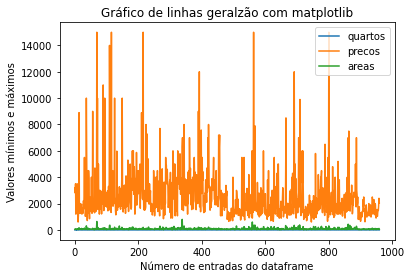

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df['quartos'])
plt.plot(df['precos'])
plt.plot(df['areas'])
plt.xlabel('Número de entradas do dataframe')
plt.ylabel('Valores mínimos e máximos')
plt.legend(['quartos', 'precos', 'areas'])
plt.title('Gráfico de linhas geralzão com matplotlib')
plt.show()

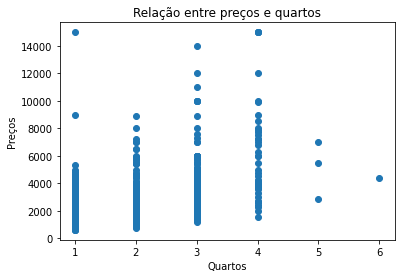

In [57]:
plt.scatter(x=df['quartos'], y=df['precos'])
plt.ylabel('Preços')
plt.xlabel('Quartos')
plt.title('Relação entre preços e quartos');

In [58]:
df[df['quartos'] == 6]

,zonas,enderecos,precos,areas,quartos
148,sul,"Rua Francisco Téles Dourado, Jardim Prudência,...",4400.0,200.0,6.0


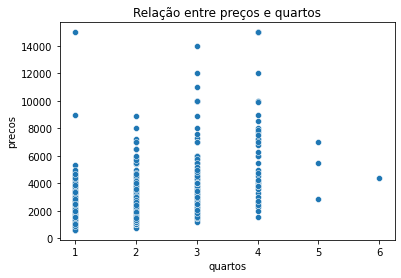

In [59]:
sns.scatterplot(x=df['quartos'], y=df['precos']).set_title('Relação entre preços e quartos');

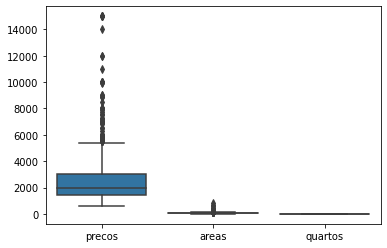

In [60]:
sns.boxplot(data=df);

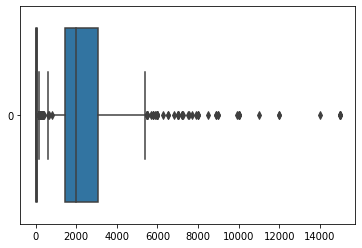

In [62]:
sns.boxplot(data=df['precos'], orient='h');

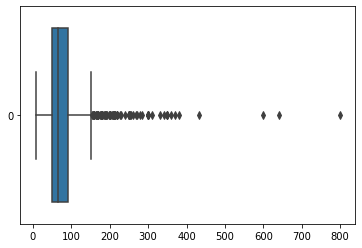

In [63]:
sns.boxplot(data=df['areas'], orient='h');

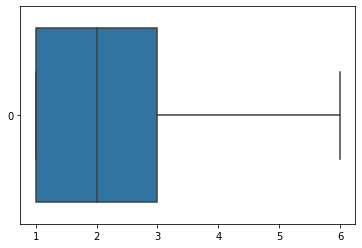

In [64]:
sns.boxplot(data=df['quartos'], orient='h');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


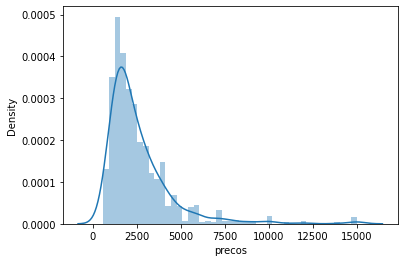

In [65]:
sns.distplot(a=df['precos']); # histograma com curva

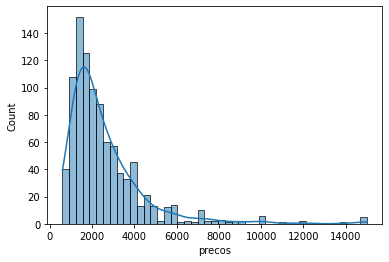

In [66]:
sns.histplot(data=df['precos'], kde=True); # histograma simples

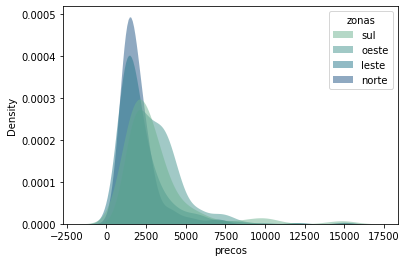

In [67]:
sns.kdeplot(
   data=df, x="precos", hue="zonas",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
);

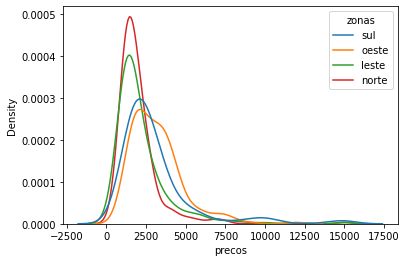

In [68]:
sns.kdeplot(
   data=df, x="precos", hue="zonas",
   fill=False, common_norm=False
);

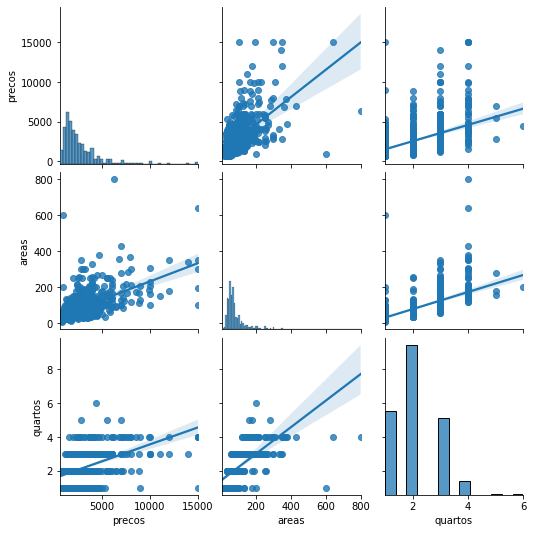

In [69]:
sns.pairplot(data=df, kind='reg');

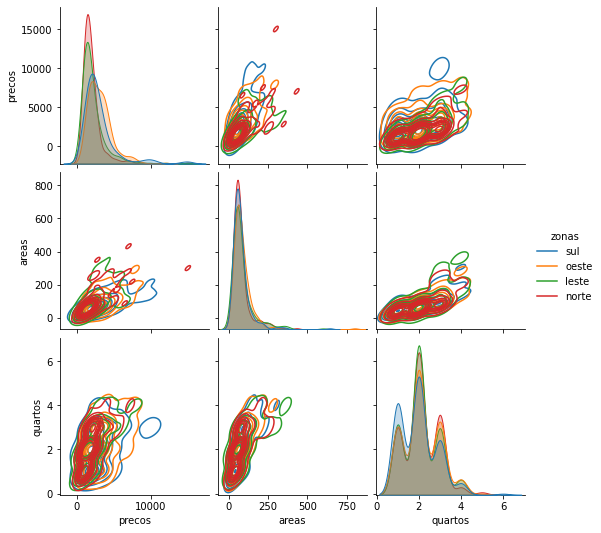

In [70]:
sns.pairplot(data=df, hue='zonas', kind='kde');

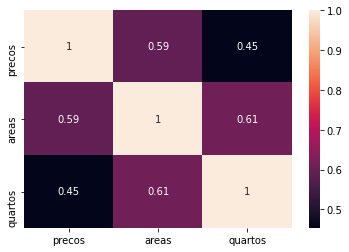

In [71]:
sns.heatmap(data=df.corr(), annot=True); # correlação de pearson

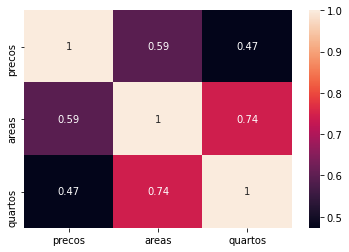

In [72]:
sns.heatmap(data=df.corr(method='spearman'), annot=True); # correlação de spearman

In [74]:
corr_spearman=df.corr(method='spearman')

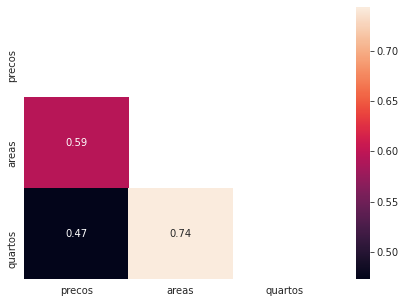

In [75]:
mask = np.zeros_like(corr_spearman)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_spearman, mask=mask, annot=True);